In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import glob

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_drawing_functions/py_drawing_functions.html

In [17]:
def get_obj_and_img_points(images):
    objpoints = []
    imgpoints = []

    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

    for filename in images:
        img = npimg.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    return objpoints, imgpoints

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def threshold_image(img):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= 30) & (scaled_sobel <= 100)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 170) & (s_channel <= 255)] = 1
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


def warp_perspective(img):
    img = np.copy(img)
    fresh = np.copy(img)
    imshape = img.shape
    img_size = (img.shape[1],img.shape[0])
    
    offset_warped = 300 #parameter to dictate where the lane lines will be in the transformed image
    from_center = 45 #parameter to dictate how far from center the trapezoid will be
    

    src_array = [[220,imshape[0]],[imshape[1]/2-from_center, 450], [imshape[1]/2+from_center+2, 450], [imshape[1]-180,imshape[0]]]
    src = np.float32(src_array)
    
    dst_array = [[offset_warped,imshape[0]],[offset_warped, 0], [imshape[1]-offset_warped, 0], [imshape[1]-offset_warped,imshape[0]]]
    dst = np.float32(dst_array)
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    warped_undrawn = cv2.warpPerspective(fresh, M, img_size, flags=cv2.INTER_LINEAR)
    
    pts = np.array(dst_array, np.int32)
    pts = pts.reshape((-1,1,2))
    drawn_warped = cv2.polylines(warped,[pts],True,(0,255,255), 4)
    
    pts = np.array(src_array, np.int32)
    pts = pts.reshape((-1,1,2))
    drawn_image = cv2.polylines(img,[pts],True,(0,255,255), 4)
    return drawn_warped, drawn_image, warped_undrawn, M_inv


def histogrammer(img):
    histogram_img = np.copy(img)
    halfway = histogram_img.shape[0]//2
    histogram_img = histogram_img[halfway:, :]
    histo = np.sum(histogram_img, axis=0)
    return histo

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    conversion_y = (30/730)
    conversion_x = (3.7/700)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    conversion_y = (30/730)
    conversion_x = (3.7/700)    
    
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fitx = 0
        right_fitx = 0
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, ploty

def measure_curvature_pixels(y_eval, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    conversion = (30/730)

    y_eval = y_eval * conversion
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad



In [4]:
images = glob.glob('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/camera_cal/calibration*')
objpoints, imgpoints = get_obj_and_img_points(images)
                                              


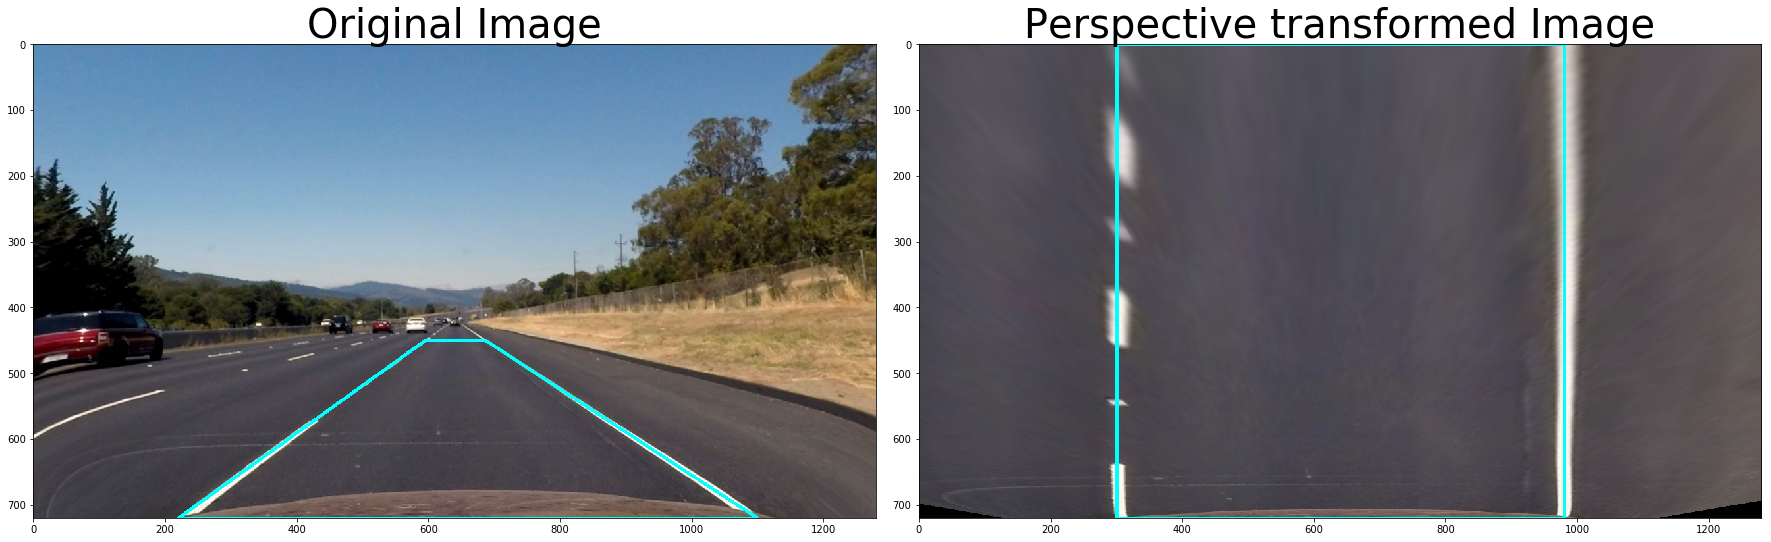

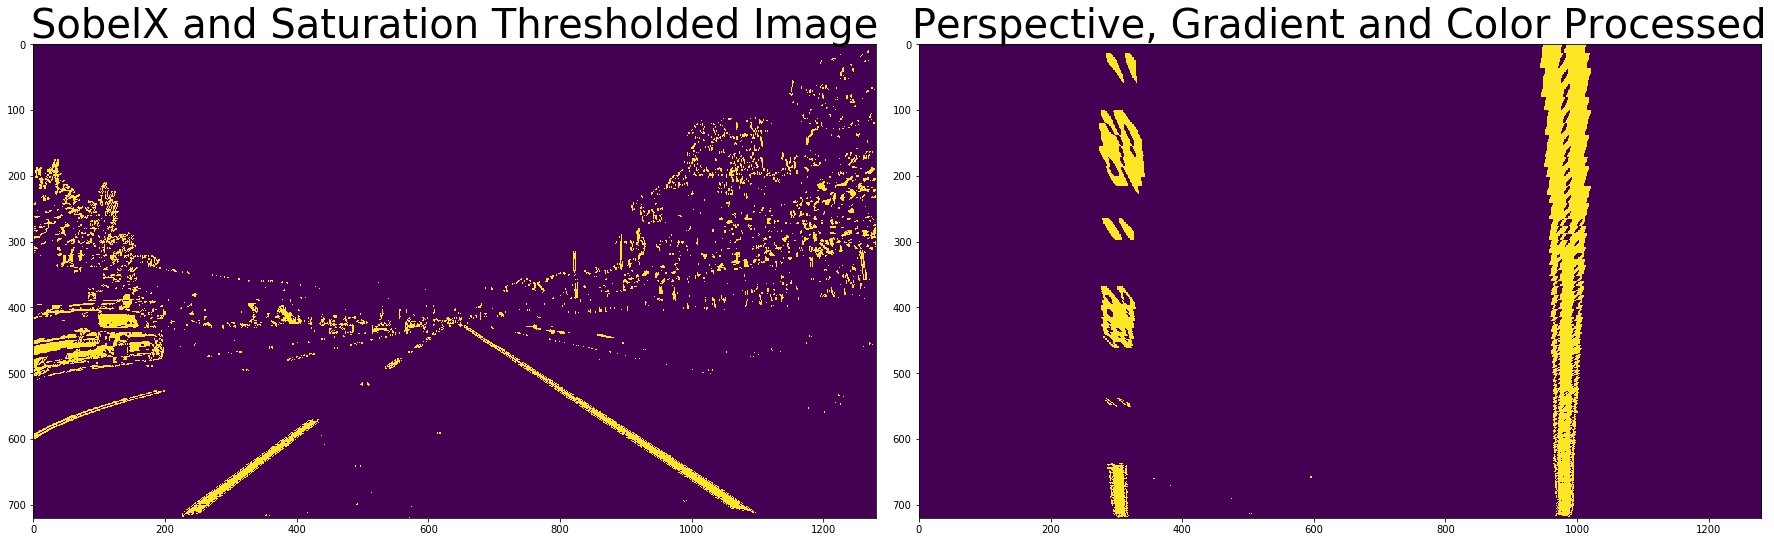

In [5]:
straight_image = npimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/test_images/straight_lines2.jpg')
undistorted_strt_img = undistort_image(straight_image, objpoints, imgpoints)

d_warp, drawn_image, warp, M_inv = warp_perspective(undistorted_strt_img)
color_and_gradient = threshold_image(undistorted_strt_img)
d_warp2, drawn2, warp2, M_inv2 = warp_perspective(color_and_gradient)
histo = histogrammer(warp2)


# Plot the result
plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(drawn_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(d_warp)
ax2.set_title('Perspective transformed Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Plot the result
plt.figure(2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(color_and_gradient)
ax1.set_title('SobelX and Saturation Thresholded Image', fontsize=40)

ax2.imshow(warp2)
ax2.set_title('Perspective, Gradient and Color Processed', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Text(0,0.5,'Vertical non zero pixel count')

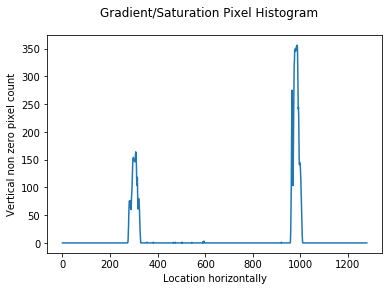

In [6]:
fig = plt.figure()
plt.plot(histo)
fig.suptitle('Gradient/Saturation Pixel Histogram')
plt.xlabel('Location horizontally')
plt.ylabel('Vertical non zero pixel count')

In [9]:
straight_image = npimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/test_images/test2.jpg')
undistorted_strt_img = undistort_image(straight_image, objpoints, imgpoints)

color_and_gradient = threshold_image(undistorted_strt_img)
d_warp2, drawn2, warp2, M_inv = warp_perspective(color_and_gradient)

[ -4.26137096e-04   5.99329434e-01   1.49104507e+02]


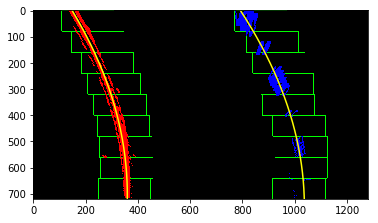

In [10]:
out_img, left_fit, right_fit = fit_polynomial(warp2)
plt.imshow(out_img)

print(left_fit)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        
right_line = Line()
left_line = Line()

right_line.best_fit = [[0 for i in range(3)] for j in range(5)]

In [20]:
#frame = npimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/test_images/test3.jpg')
left_line.allx = None
right_line.allx = None                                             
def advanced_lane_pipeline(frame):
    image = npimg.imread(frame)
    
    undistorted_strt_img = undistort_image(image, objpoints, imgpoints)
    color_and_gradient = threshold_image(undistorted_strt_img)
    d_warp2, drawn2, warp2, M_inv = warp_perspective(color_and_gradient)
    
    
    if right_line.allx == None and left_line.allx == None:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warp2)
        left_fitx, right_fitx, ploty = fit_poly(warp2.shape, leftx, lefty, rightx, righty)
        
        
        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty
        
        right_line.current_fit = right_fitx
        left_line.current_fit = left_fitx
        
        
        
    else:
        left_fitx, right_fitx, ploty = search_around_poly(warp2, left_line.current_fit, right_line.current_fit)
        
         
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp2).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
    
    #Set your variables for your lines
    
    #right_line.recent_xfitted.append(right_fitx)
    #left_line.recent_xfitted.append(left_fitx)
        
        

In [ ]:
left_line.allx = None
right_line.allx = None 

test_output = '/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/test_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('/home/workspace/CarND-Advanced-Lane-Lines/self-driving-car-engineer-nanodegree/CV-DL-and-sensor-fusion/p2-advanced-lanefinding/project_video.mp4')
test_clip = clip2.fl_image(advanced_lane_pipeline)
%time yellow_clip.write_videofile(test_output, audio=False)